In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn
from multiprocessing import Pool
from matplotlib.patches import Rectangle


sys.path.append("../functions")

from Utility import *
from Plotting import *

%matplotlib inline
%load_ext jupyter_black

plt.style.use("../matplotlib_style.txt")

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Reading Data


In [4]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
# selecting usefull columns
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]
# excluding chance level subjects
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

## Low meta and high meta agents


In [16]:
high_syn_df = lv_induction_data.copy()
high_syn_df["cj"] = np.where(high_syn_df["cor"] == 1, 5, 1)
low_syn_df = lv_induction_data.copy()
low_syn_df["cj"] = np.random.uniform(1, 5, len(high_syn_df))
human_qsr = (
    lv_induction_data.groupby("sub")
    .apply(group_qsr)
    .reset_index()
    .rename(columns={0: "QSR", "sub": "subject"})
)

Statistics=36.0, p=1.1786678718505623e-09
Statistics=0.0, p=1.6256984569330967e-10
Statistics=0.0, p=1.6256984569330967e-10


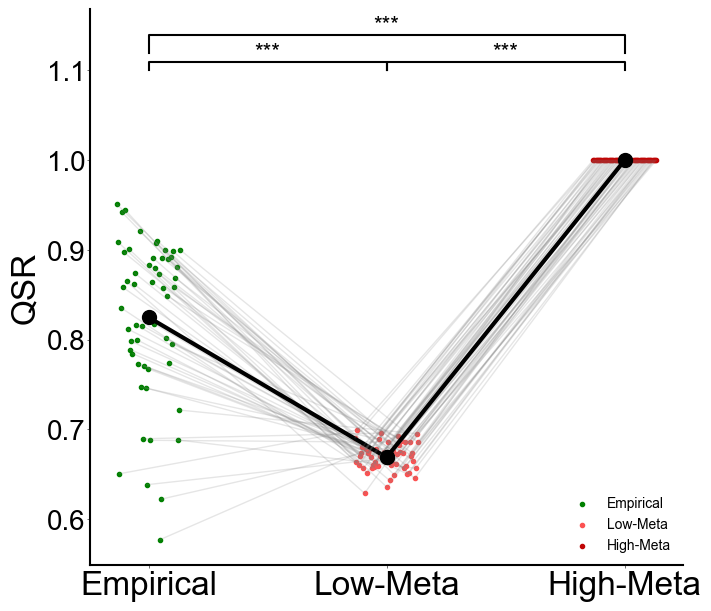

In [17]:
groups = ["Empirical", "Low-Meta", "High-Meta"]

plt.figure(figsize=(7, 6))


hm_syn_qsr = (
    high_syn_df.groupby("sub")
    .apply(group_qsr)
    .reset_index()
    .rename(columns={0: "QSR", "sub": "subject"})
)
lm_syn_qsr = (
    low_syn_df.groupby("sub")
    .apply(group_qsr)
    .reset_index()
    .rename(columns={0: "QSR", "sub": "subject"})
)
qsr_df = merge_result_df([human_qsr, lm_syn_qsr, hm_syn_qsr], groups, 200, subjects)

comparison_plot(
    qsr_df,
    "QSR",
    groups,
    "",
    [["Empirical", "Low-Meta"], ["Low-Meta", "High-Meta"], ["Empirical", "High-Meta"]],
    [1.1, 1.1, 1.12],
    [0.01, 0.01, 0.02],
    y_label="QSR",
)

plt.savefig("../figs/fake_agents_qsr.png", dpi=400)

## Fit synthetic agents to Bakcward and Forward models

In [18]:
from Fitting import fit_for_all_subjects
from Forward import forward_fitting

params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
n_fitting = 3
n_threads = 2

res = fit_for_all_subjects(
    params_ranges, n_threads, n_fitting, subjects, high_syn_df, forward_fitting
)

hsyn_forward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], subjects
)
hsyn_forward_df["hbound"] = (5 - hsyn_forward_df["lbound"]) * (
    hsyn_forward_df["bound_range"]
) + hsyn_forward_df["lbound"]

In [19]:
from Backward import backward_fitting

res = fit_for_all_subjects(
    params_ranges, n_threads, n_fitting, subjects, high_syn_df, backward_fitting
)

hsyn_backward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], subjects
)
hsyn_backward_df["hbound"] = (5 - hsyn_backward_df["lbound"]) * (
    hsyn_backward_df["bound_range"]
) + hsyn_backward_df["lbound"]

In [ ]:
from Forward import simulate_with_params

df_lists = []
count = 0
for i in range(30):
    low_syn_df["cj"] = np.random.uniform(1, 5, len(high_syn_df))
    n_fitting = 5
    res = fit_for_all_subjects(
        params_ranges, n_threads, n_fitting, subjects, low_syn_df, backward_fitting
    )

    lsyn_backward_df = make_df_after_fitting(
        res, ["alpha", "beta", "lbound", "bound_range"], subjects
    )

    lsyn_backward_df["hbound"] = (5 - lsyn_backward_df["lbound"]) * (
        lsyn_backward_df["bound_range"]
    ) + lsyn_backward_df["lbound"]

    lsyn_backward_simulation_df = simulate_with_params(
        lsyn_backward_df, lv_induction_data, subjects
    )
    lsyn_backward_simulation_df["agent_nr"] = count
    df_lists.append(lsyn_backward_simulation_df)
    count += 1

In [21]:
lsyn_backward_simulation_df = pd.concat(df_lists, axis=0, ignore_index=True)
lsyn_var_df = (
    lsyn_backward_simulation_df.groupby(["sub", "agent_nr"])
    .agg({"cor": "mean"})
    .reset_index()
    .groupby(["sub"])["cor"]
    .apply(scipy.stats.sem)
    .reset_index()
)

hsyn_backward_simulation_df = simulate_with_params(
    hsyn_backward_df, lv_induction_data, subjects
)
hsyn_forward_simulation_df = simulate_with_params(
    hsyn_forward_df, lv_induction_data, subjects
)

groups = ["Forward", "Low-Meta", "High-Meta"]

fwd_avg_df = (
    hsyn_forward_simulation_df.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

hm_avg_df = (
    hsyn_backward_simulation_df.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

lm_avg_df = (
    lsyn_backward_simulation_df.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

avg_df = merge_result_df([fwd_avg_df, lm_avg_df, hm_avg_df], groups, 200, subjects)
avg_df.rename(
    columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
    inplace=True,
)

Statistics=21.0, p=5.222383030755911e-10
Statistics=14.0, p=3.551964630124655e-10
Statistics=523.0, p=0.18938984031024841


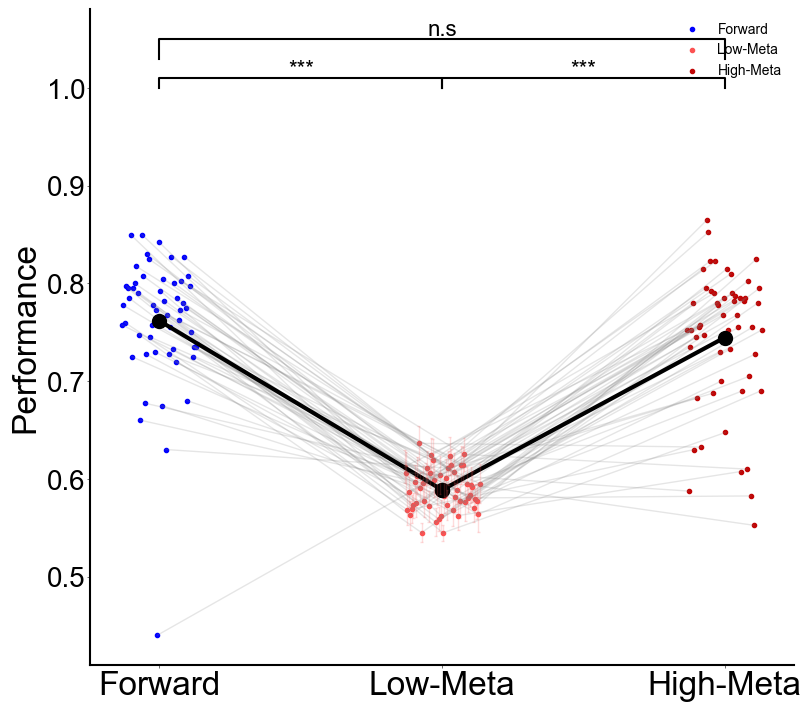

In [22]:
plt.figure(figsize=(8, 7))

comparison_plot(
    avg_df,
    "accuracy",
    groups,
    "",
    [["Forward", "Low-Meta"], ["Low-Meta", "High-Meta"], ["Forward", "High-Meta"]],
    [1, 1, 1.03],
    [0.01, 0.01, 0.02],
    y_label="Performance",
    legend="upper right",
    var_df=lsyn_var_df,
)
plt.savefig("../figs/fake_agents_accuracy.png", dpi=400)

## Fake Agents Spectrum Fitting

In [9]:
%%time
import functools
from Fake_Agent import noisy_agent

params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]

n_reps = 1  # number of fake agents for each variance
n_fitting = 10  # number of fitting per fake agent
n_threads = 4  # number of async threads for fitting

noise_vars = np.linspace(0, 4, 30)
cnt = 1
for subject_id in subjects:
    if subject_id in [45628, 45664, 45745, 45763, 45829, 45640, 45682, 45760, 45805]:
        continue

    partial_func = functools.partial(
        noisy_agent,
        n_reps=n_reps,
        n_fitting=n_fitting,
        data=lv_induction_data,
        params_ranges=params_ranges,
        subject_id=subject_id,
        subjects=subjects,
    )
    with Pool(n_threads) as p:
        result = p.map(partial_func, noise_vars)
    result = np.array(result)
    noises = []
    noise_perfs_arr = []
    noise_metai_arr = []
    noise_qsr_arr = []
    noise_qsr_scaled_arr = []
    for i in range(n_reps):
        noises.extend(noise_vars)
        noise_perfs_arr.extend(result[:, 0, i])
        noise_metai_arr.extend(result[:, 1, i])
        noise_qsr_arr.extend(result[:, 2, i])
        noise_qsr_scaled_arr.extend(result[:, 3, i])
    noise_df = pd.DataFrame(
        list(
            zip(
                noises,
                noise_perfs_arr,
                noise_metai_arr,
                noise_qsr_arr,
                noise_qsr_scaled_arr,
            )
        ),
        columns=["noise_var", "perf", "metai", "QSR", "QSR_scaled"],
    )
    noise_df["subject"] = subject_id
    noise_df.to_csv("../results/fake_agents/noise_sub_" + str(subject_id) + ".csv")

CPU times: user 1.53 s, sys: 1.22 s, total: 2.75 s
Wall time: 7min 57s


## Fake Agents Spectrum Analysis

In [12]:
noise_df_list = []
for subject_id in subjects:
    if subject_id in [45628, 45664, 45745, 45763, 45829, 45640, 45682, 45760, 45805]:
        continue

    noise_df = pd.read_csv(
        "../results/fake_agents/noise_sub_" + str(subject_id) + ".csv"
    )
    noise_df_list.append(noise_df)
df = pd.concat(noise_df_list, axis=0, ignore_index=True)

In [24]:
fwd_avg_df["cor"].mean()

0.7616203703703703

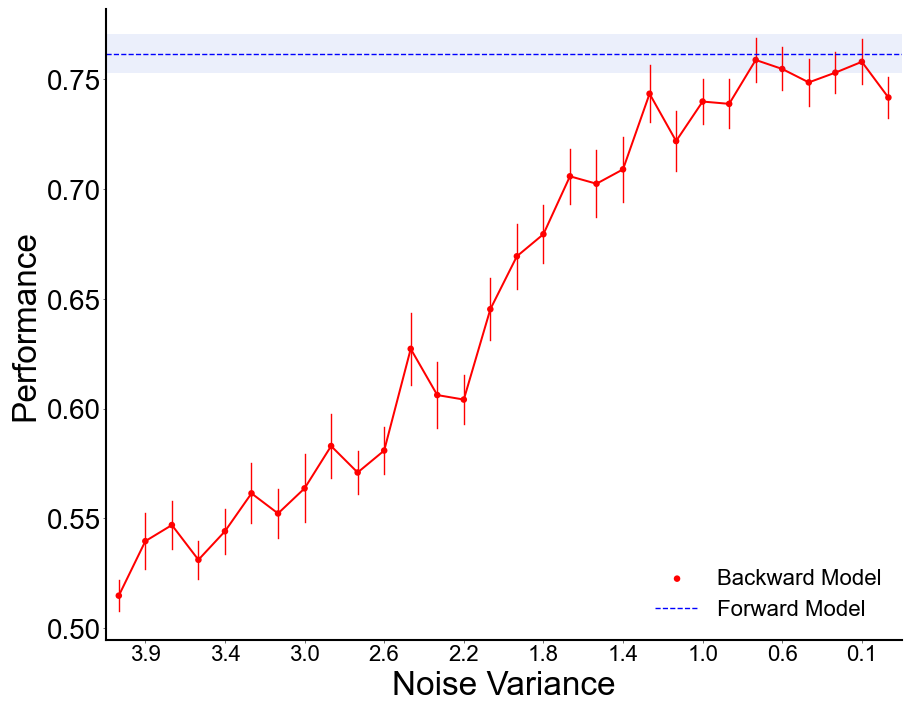

In [35]:
plt.figure(figsize=(9, 7))

noise_sub_df = (
    df.groupby(["subject", "noise_var"]).mean(["perf", "metai"]).reset_index()
)
rounded_df = noise_sub_df.round({"noise_var": 1})

fwd_averg_perf = fwd_avg_df["cor"].mean()
fwd_averg_perf_se = fwd_avg_df["cor"].sem()

seaborn.pointplot(
    data=rounded_df,
    x="noise_var",
    y="perf",
    color="red",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward Model",
)

plt.axhline(fwd_averg_perf, linestyle="--", label="Forward Model", color="blue")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (-1, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="royalblue",
    )
)


plt.gca().invert_xaxis()

plt.xticks(range(1, 30, 3))

plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
plt.legend(fontsize=16)
plt.xlabel("Noise Variance", fontsize=24)
plt.ylabel("Performance", fontsize=24)
plt.savefig("../figs/noisy_agents_spect.png".format(subject_id), dpi=400)

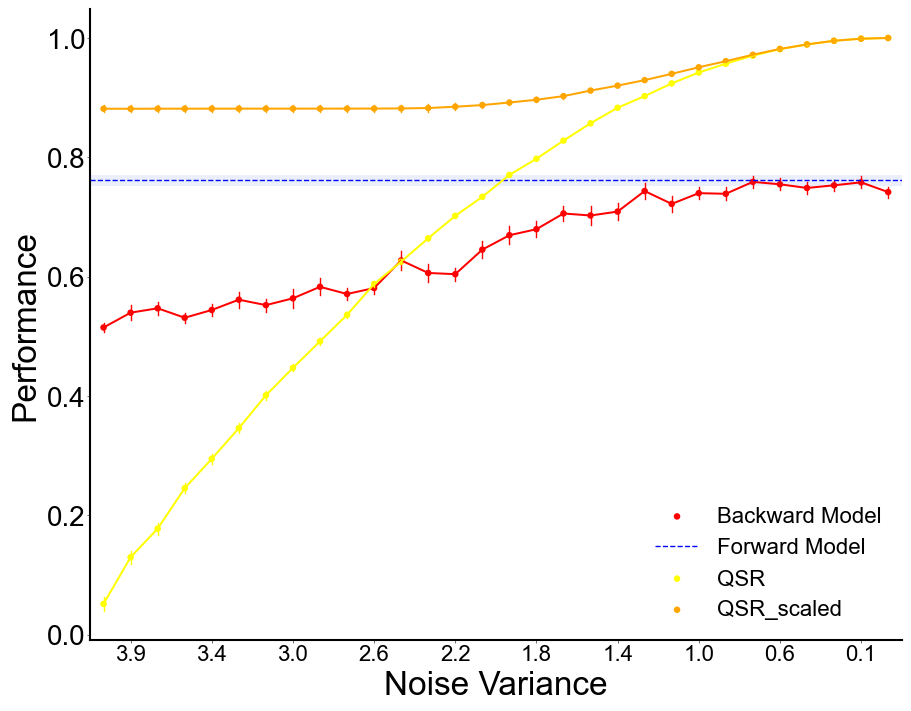

In [37]:
plt.figure(figsize=(9, 7))

noise_sub_df = (
    df.groupby(["subject", "noise_var"]).mean(["perf", "metai"]).reset_index()
)
rounded_df = noise_sub_df.round({"noise_var": 1})

fwd_averg_perf = fwd_avg_df["cor"].mean()
fwd_averg_perf_se = fwd_avg_df["cor"].sem()

seaborn.pointplot(
    data=rounded_df,
    x="noise_var",
    y="perf",
    color="red",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="Backward Model",
)

plt.axhline(fwd_averg_perf, linestyle="--", label="Forward Model", color="blue")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.add_patch(
    Rectangle(
        (-1, fwd_averg_perf - fwd_averg_perf_se),
        100,
        2 * fwd_averg_perf_se,
        alpha=0.1,
        ls="",
        color="royalblue",
    )
)

noise_sub_df = df.groupby(["subject", "noise_var"]).mean("QSR").reset_index()
rounded_df = noise_sub_df.round({"noise_var": 1})
seaborn.pointplot(
    data=rounded_df,
    x="noise_var",
    y="QSR",
    color="yellow",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="QSR",
)


noise_sub_df = df.groupby(["subject", "noise_var"]).mean("QSR_scaled").reset_index()
rounded_df = noise_sub_df.round({"noise_var": 1})
seaborn.pointplot(
    data=rounded_df,
    x="noise_var",
    y="QSR_scaled",
    color="orange",
    errwidth=1,
    scale=0.8,
    errorbar="se",
    label="QSR_scaled",
)


plt.gca().invert_xaxis()

plt.xticks(range(1, 30, 3))

plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
plt.legend(fontsize=16)
plt.xlabel("Noise Variance", fontsize=24)
plt.ylabel("Performance", fontsize=24)
plt.savefig("../figs/noisy_agents_qsr_spect.png".format(subject_id), dpi=400)